# Speaker diarization.
In this project we wish to do Speaker Diarization. Specifically we wish to build custom pipelines in order to answer the following questions:
- Which embeddings are best for speaker diarization?
- Which clustering algorithms are best for speaker diarization?
- Which embedding + Clustering algorithm combination is best for speaker diarization?
- Does Clustering Algorithms on Deep Neural Network embeddings outperform traditional clustering algorithms?
- Can end-to-end Deep Neural Network models outperform traditional clustering algorithms?
- Which Voice activity detections to use for speaker diarization?


The ground truth are the RTTM files. The RTTM files are in the following format:
```

SPEAKER <NA> 1 0.00 0.39 <NA> <NA> spk_0 <NA>
SPEAKER <NA> 1 0.39 0.01 <NA> <NA> spk_1 <NA>

```
The first number is the start time, the second number is the duration, and the last number is the speaker id.



    

## Which embeddings are best for speaker diarization?
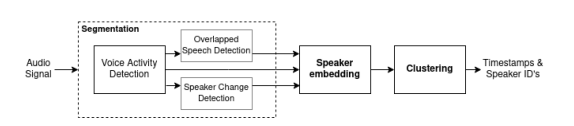

The focus being on the embeddings, we will use the following embeddings:
- I-vector
- D-vectors (Deep Speaker Embeddings)

To keep things simple, we will just use one clustering algorithm, K-means. We will use the following metrics to evaluate the embeddings:
- DER

### All imports 

In [2]:
# Typical imports
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import speechbrain as sb

# Scipy
from scipy.spatial.distance import cdist


# All Pyannote imports
from pyannote.audio import Pipeline
from pyannote.core import Segment, Annotation
from pyannote.audio import Model, Inference
from pyannote.audio import Audio

# Loading the envs
load_dotenv("auths.env")
api_key = os.getenv("API_KEY")

### Loading the train data and the ground truth on the train data
- Below is a playground to load the train data and the ground truth on the train data for one of the files. Later this will be done on all the files. 

In [3]:
train_data_path = "../Dataset/Audio/Dev"
train_label_path = "../Dataset/RTTMs/Dev"

# Experimental data --> just one audio file and its corresponding label
dummy_train_data_path = "../Dataset/Audio/Dev/ahnss.wav"
dummy_train_label_path = "../Dataset/RTTMs/Dev/ahnss.rttm"


# Load the pipeline
pipeline = Pipeline.from_pretrained(
    "pyannote/voice-activity-detection", use_auth_token=api_key
)
pipeline.to(torch.device("cuda"))

# 1. Voice Activity Detection
vad_pipeline = pipeline(dummy_train_data_path)
vad_timeline = vad_pipeline.get_timeline().support()

# 2. Overlapped speech detection
osd_pipeline = Pipeline.from_pretrained(
    "pyannote/overlapped-speech-detection", use_auth_token=api_key
)
output = osd_pipeline(dummy_train_data_path)
osd_timeline = output.get_timeline().support()

# Combine the two timelines 
combined_timeline = vad_timeline.union(osd_timeline)
combined_annotation = Annotation()
for segment in combined_timeline:
    combined_annotation[segment] = "speech"



Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\rakin\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\059e96f964841d40f1a5e755bb7223f76666bba4\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.2.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.


Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\rakin\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\059e96f964841d40f1a5e755bb7223f76666bba4\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.2.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.


In [5]:
# Load the speaker embedding model
embedding_model = Model.from_pretrained("pyannote/embedding", use_auth_token=api_key)
inference = Inference(embedding_model, window="whole")

# Initialize audio utility
audio = Audio(sample_rate=16000)

# Extract embeddings for each segment
embeddings = []
segments = []

min_length = 1024  # Set an appropriate minimum length for the model
audio_duration = audio.get_duration(
    dummy_train_data_path
)  # Get the duration of the audio file

for segment in tqdm(combined_annotation.itersegments(), desc="Extracting embeddings"):
    # Ensure the segment is within audio bounds
    start_time = segment.start
    end_time = segment.end
    if end_time > audio_duration:
        print(f"Adjusting segment end time from {end_time} to {audio_duration}")
        end_time = audio_duration
        if start_time >= end_time:
            print(
                f"Skipping segment with start time {start_time} and end time {end_time}"
            )
            continue
        segment = Segment(start_time, end_time)

    try:
        waveform, _ = audio.crop(dummy_train_data_path, segment)

        # Print shape for debugging

        # Ensure the segment is long enough
        if waveform.shape[1] < min_length:
            padding = min_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding), "constant", 0)

        # Print shape after padding

        # Ensure the waveform is a 2D tensor with shape [1, length]
        if waveform.ndim == 1:
            waveform = waveform.unsqueeze(0)

        embedding = inference({"waveform": waveform, "sample_rate": 16000})
        embeddings.append(embedding)  # Directly append the numpy array
        segments.append(segment)
    except ValueError as e:
        print(f"ValueError processing segment {segment}: {e}")
        continue
    except RuntimeError as e:
        print(f"RuntimeError processing segment {segment}: {e}")
        continue
    except Exception as e:
        print(f"Unexpected error processing segment {segment}: {e}")
        continue

Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\rakin\.cache\torch\pyannote\models--pyannote--embedding\snapshots\4db4899737a38b2d618bbd74350915aa10293cb2\pytorch_model.bin`
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\rakin\.cache\torch\pyannote\models--pyannote--embedding\snapshots\4db4899737a38b2d618bbd74350915aa10293cb2\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.2.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.2.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.


Extracting embeddings: 9it [00:00, 24.31it/s]

RuntimeError processing segment [ 00:02:27.045 -->  00:02:27.265]: Calculated padded input size per channel: (2). Kernel size: (7). Kernel size can't be greater than actual input size
RuntimeError processing segment [ 00:03:43.000 -->  00:03:43.169]: Calculated padded input size per channel: (3). Kernel size: (5). Kernel size can't be greater than actual input size


Extracting embeddings: 36it [00:00, 49.22it/s]

RuntimeError processing segment [ 00:08:03.212 -->  00:08:03.432]: Calculated padded input size per channel: (2). Kernel size: (7). Kernel size can't be greater than actual input size
RuntimeError processing segment [ 00:08:04.647 -->  00:08:04.934]: Calculated padded input size per channel: (6). Kernel size: (7). Kernel size can't be greater than actual input size


Extracting embeddings: 49it [00:01, 42.18it/s]

RuntimeError processing segment [ 00:09:52.799 -->  00:09:53.001]: Calculated padded input size per channel: (1). Kernel size: (7). Kernel size can't be greater than actual input size
Adjusting segment end time from 664.31534375 to 664.2939375
